# Accounting for Seasonality

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Model to Forecast the Total Number of Monthly Passengers for an Airline

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


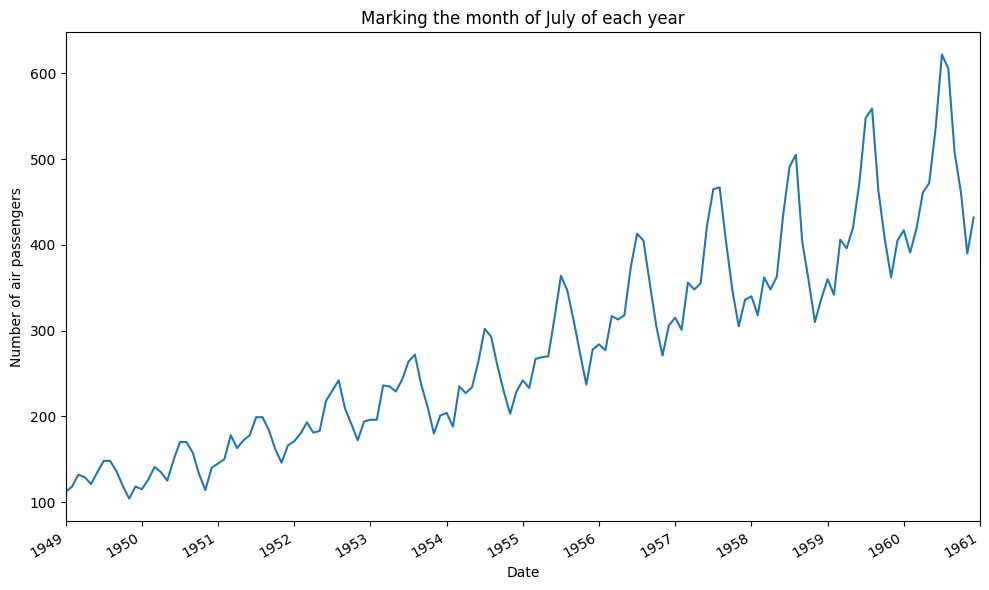

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.set_title('Marking the month of July of each year')
ax.set_xlim(0, 143)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

*Monthly total number of air passengers for an airline, from January 1949 to
December 1960. You’ll notice a clear seasonal pattern in the series, with peak traffic
occurring toward the middle of each year.*

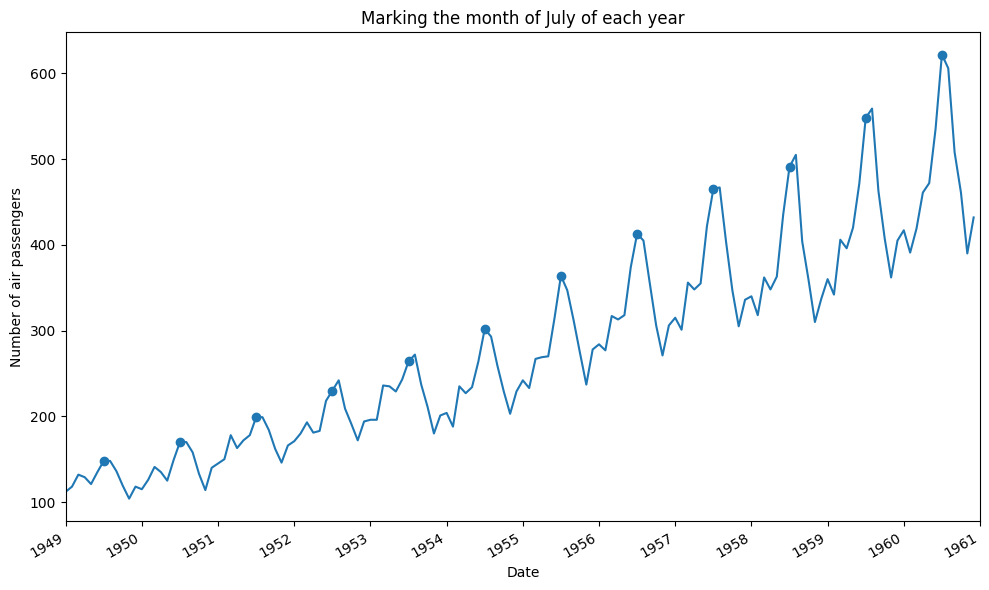

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['Month'], df['Passengers'], markevery=np.arange(6, 145, 12), marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.set_title('Marking the month of July of each year')
ax.set_xlim(0, 143)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

*Marking the month of July of each year. You can see how the month of July
has the highest number of air passengers. Therefore, it would make sense if July of the
following year also saw the highest number of air passengers in the year. That kind of
information is captured by the seasonal parameters P, D, Q, and m of the
SARIMA(p,d,q)(P,D,Q)m model.*

## Identifying seasonal patterns in a time series

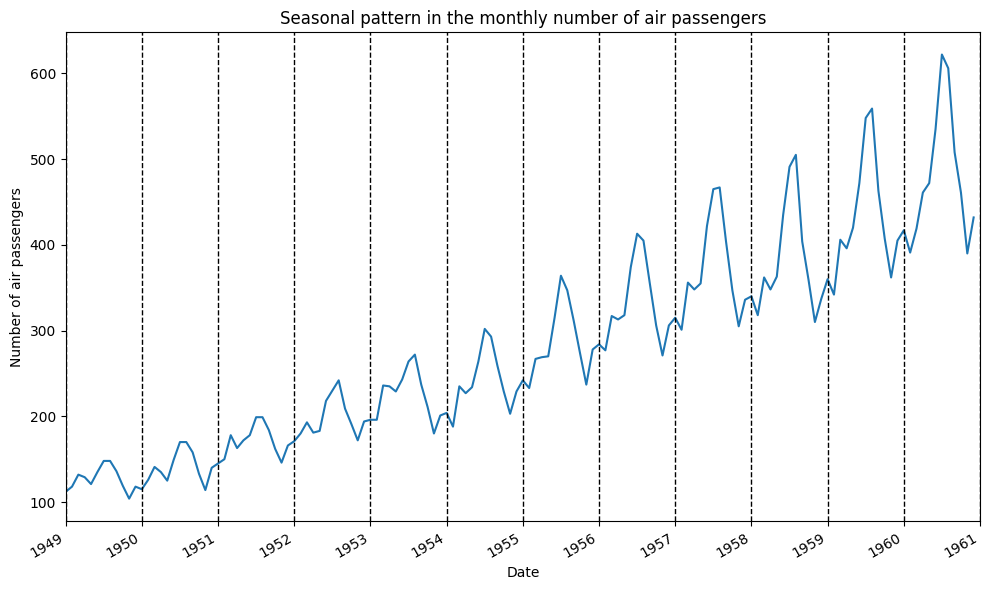

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['Month'], df['Passengers'])
for i in np.arange(0, 145, 12):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.set_title('Seasonal pattern in the monthly number of air passengers')
ax.set_xlim(0, 143)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

*Highlighting the seasonal pattern in the monthly number of air passengers.
The dashed vertical lines separate periods of twelve months. We can clearly see how a
peak occurs in the middle of each year, and there is a very similar pattern for the
beginning and end of each year. This observation is usually enough to determine that the
dataset is seasonal.*

## Decomposition

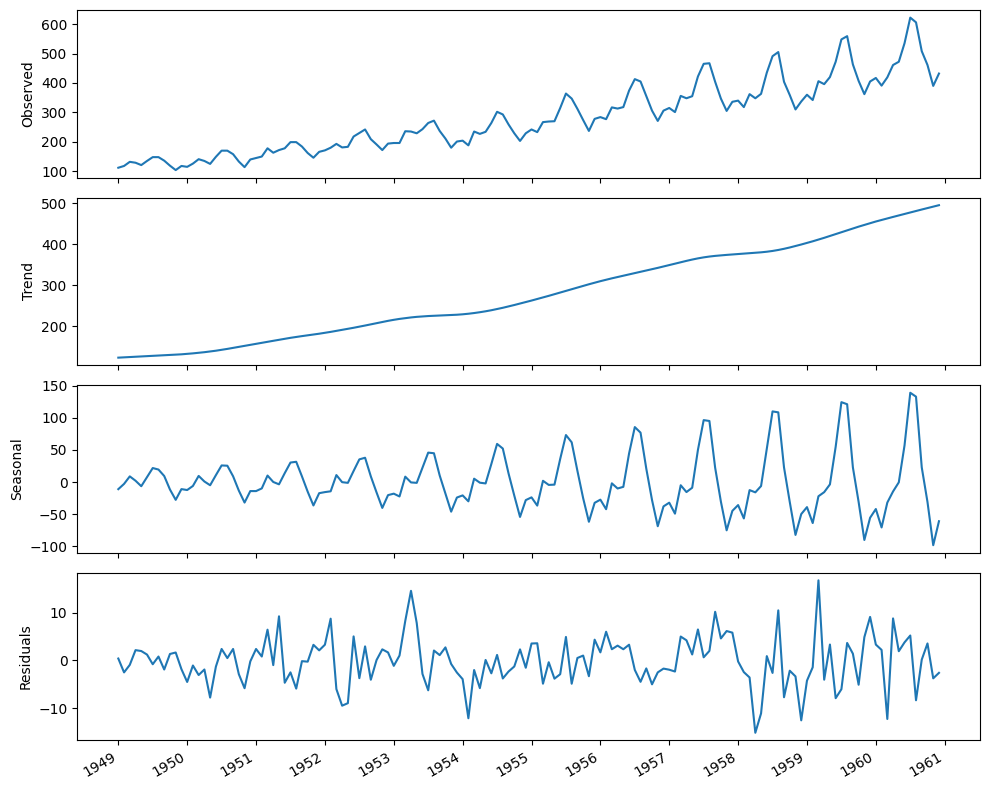

In [14]:
decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

Decomposing the dataset for air passengers: 
                       
1. The first plot shows the observed data. 
2. The second plot shows the trend component, which tells us that the number of air passengers is increasing over time. 
3. The third plot displays the seasonal component, and we can clearly see a repeating pattern through time. 
4. Finally, the last plot shows the residuals, which are variations in the data that cannot be explained by the trend or the seasonal
component.

## Forecasting with ARIMA

In [17]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df['Passengers'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 0.8153688792060352
p-value: 0.9918802434376408

p-value > alpha; H0: Not Stationary


In [18]:
# First-Order differencing
eps_diff1 = np.diff(df['Passengers'], n=1)

ad_fuller_result1 = adfuller(eps_diff1)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -2.8292668241699945
p-value: 0.05421329028382621

p-value > alpha; H0: Not Stationary


In [19]:
# Second-Order differencing
eps_diff2 = np.diff(eps_diff1, n=1)

ad_fuller_result2 = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result2[0]}')
print(f'p-value: {ad_fuller_result2[1]}')
print()

if ad_fuller_result2[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -16.38423154246852
p-value: 2.732891850014085e-29

p-value < alpha; Ha: Stationary


    Since the series was differenced twice to become stationary, d = 2.

#### Visualizing Transformations

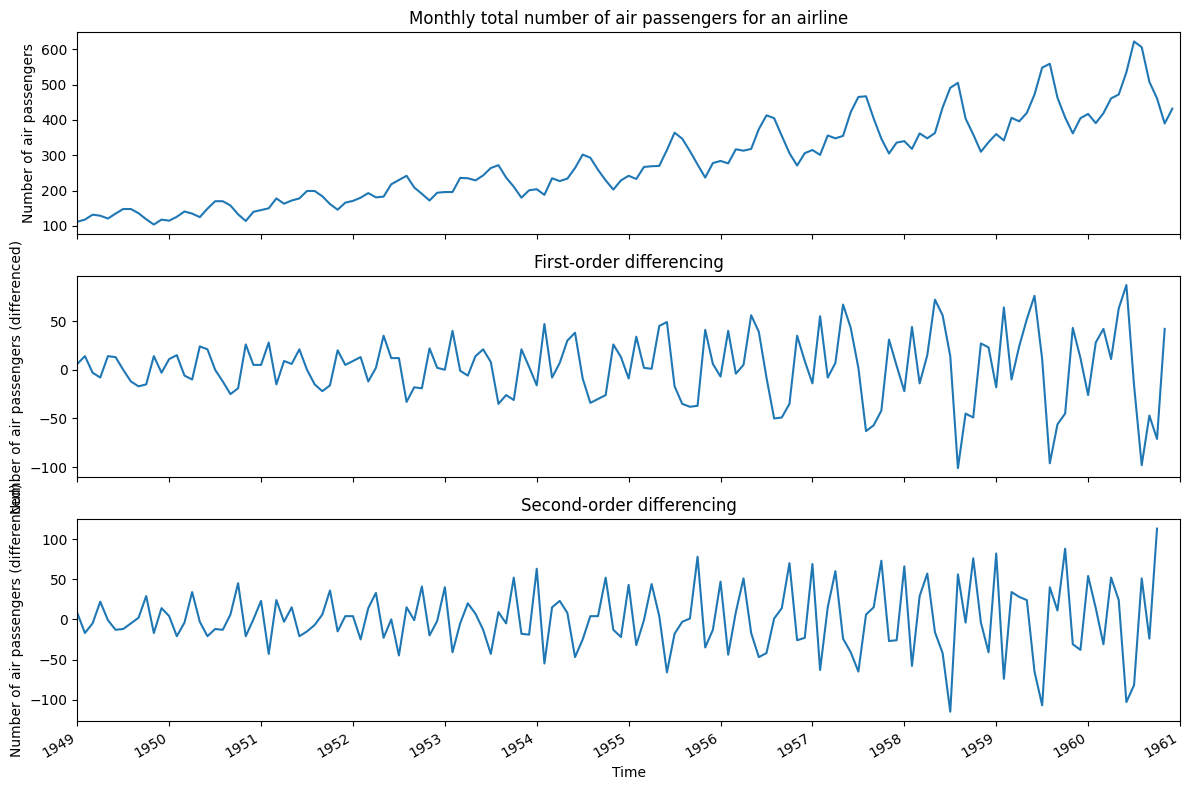

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12, 8))

ax1.plot(df['Month'], df['Passengers'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of air passengers')
ax1.set_title('Monthly total number of air passengers for an airline')
ax1.set_xlim(0, 143)

ax2.plot(eps_diff1)
ax2.set_xlabel('Time')
ax2.set_ylabel('Number of air passengers (differenced)')
ax2.set_title('First-order differencing')

ax3.plot(eps_diff2)
ax3.set_xlabel('Time')
ax3.set_ylabel('Number of air passengers (differenced)')
ax3.set_title('Second-order differencing')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [23]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [24]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2   #<==== the series was differenced twice to become stationary
D = 0
s = 12  #<==== expected seasonality

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]  # Train set is all data points less the 12 last points

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.890750
1,"(11, 4, 0, 0)",1019.035122
2,"(11, 5, 0, 0)",1020.465125
3,"(11, 1, 0, 0)",1021.027139
4,"(11, 7, 0, 0)",1021.662838
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


This returns a DataFrame where the model with the lowest AIC is a
SARIMA(11,2,3)(0,0,0)12 model, which is equivalent to an ARIMA(11,2,3) model.

#### Fit Best Model

In [27]:
# Define a SARIMAX model with specified AR(11), I(2), MA(3) parameters
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)

# Fit the model
ARIMA_model_fit = ARIMA_model.fit(disp=False)

# Display the summary
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  132
Model:              SARIMAX(11, 2, 3)   Log Likelihood                -493.445
Date:                Tue, 18 Feb 2025   AIC                           1016.891
Time:                        09:44:32   BIC                           1059.904
Sample:                             0   HQIC                          1034.368
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8259      0.100     -8.286      0.000      -1.021      -0.631
ar.L2         -0.9638      0.049    -19.651      0.000      -1.060      -0.868
ar.L3         -0.8515      0.087     -9.768      0.000      -1.022      -0.681
ar.L4         -0.9532      0.047    -20.308      0.000      -1.045      -0.861
ar.L5         -0.8319      0.091     -9.104      0.000      -1.011      -0.653
ar.L6         -0.9499      0.043    -22.122      0.000      -1.034      -0.866
ar.L7         -0.8340      0.089     -9.397      0.000      -1.008      -0.660
ar.L8         -0.9627      0.049    -19.602      0.000      -1.059      -0.866
ar.L9         -0.8259      0.086     -9.641      0.000      -0.994      -0.658
ar.L10        -0.9582      0.031    -30.616      0.000      -1.020      -0.897
ar.L11        -0.8090      0.095     -8.521      0.000      -0.995      -0.623
ma.L1         -0.3290      0.136     -2.422      0.015      -0.595      -0.063
ma.L2          0.2137      0.159      1.342      0.180      -0.098       0.526
ma.L3         -0.2942      0.141     -2.086      0.037      -0.571      -0.018
sigma2       104.9376     17.913      5.858      0.000      69.828     140.047
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.69
Prob(Q):                              0.94   Prob(JB):                         0.16
Heteroskedasticity (H):               2.23   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analyzing Residuals

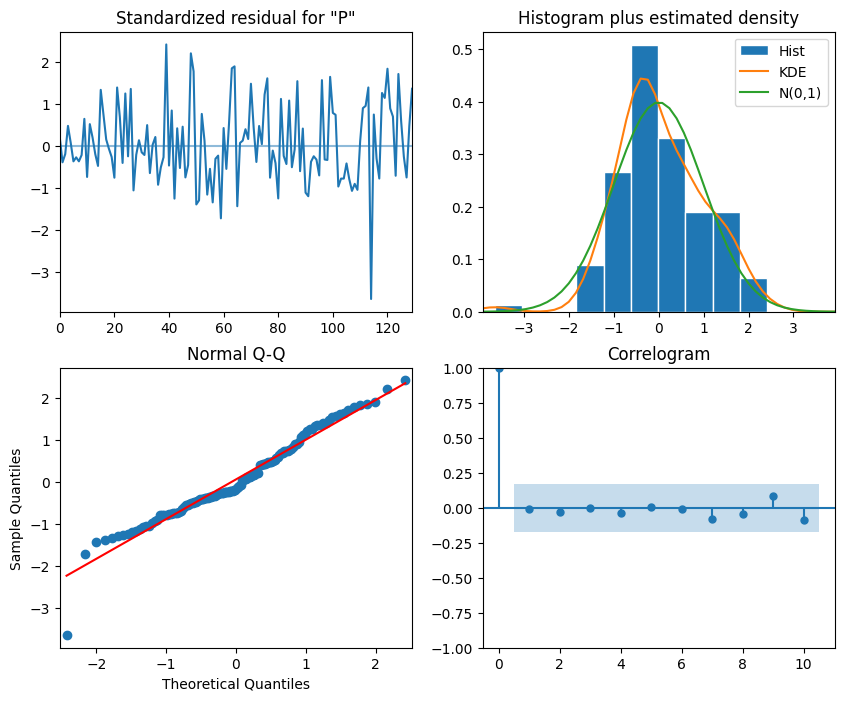

In [29]:
# Extract the residuals (errors) from the fitted model
residuals = ARIMA_model_fit.resid 

# Diagnostic plots for the model, including residuals and other model checks
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

##### Residuals’ diagnostics of the ARIMA(11,2,3) model:

In the **top-left** plot, the residuals have no trend with a variance that seems fairly constant over time, which resembles the behavior of white
noise. The **top-right** plot shows the distribution of the residuals, which approaches a normal distribution,
despite the unusual peak. This is further confirmed by the **Q-Q plot** at the bottom left, which displays a
fairly straight line that lies on y = x. Finally, the correlogram in the **bottom-right** plot shows no significant
autocorrelation coefficients after lag 0, which is exactly like white noise. From this analysis, the
residuals resemble white noise.

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,6.580342,0.010311
2,6.710784,0.034896
3,6.959364,0.073204
4,7.786726,0.099711
5,8.415651,0.134767
6,8.740414,0.188712
7,9.611334,0.211689
8,9.838773,0.276525
9,9.849403,0.362814
10,11.663828,0.308185


The returned p-values are all greater than 0.05 except for the first two values. This
means that, according to the Ljung-Box test, we reject the null hypothesis with a 5%
chance of being wrong, since we set our significance boundary to 0.05. However, the
third value and onwards are all greater than 0.05, so we reject the null hypothesis, concluding that the residuals are uncorrelated starting at lag 3.

This is an interesting situation to dissect, because the graphical analysis of the
residuals leads us to conclude that they resemble white noise, but the Ljung-Box test
points to some correlation at lags 1 and 2. This means that our ARIMA model is not
capturing all the information from the da

In this case, we’ll move forward with the model, because we know that we are modeling seasonal data with a non-seasonal model. Therefore, the Ljung-Box test is really
telling us that our model is not perfect, but that’s okay, because part of this exercise is
to compare the performance of ARIMA and SARIMA and demonstrate that SARIMA
is the way to go when dealing with seasonal data.ta.

In [33]:
test = df.iloc[-12:]  # Test set are the last 12 data points

test['naive_seasonal'] = df['Passengers'].iloc[120:132].values # The naive seasonal forecast reuses the data from 1959

test

,Month,Passengers,naive_seasonal
132,1960-01,417,360
133,1960-02,391,342
134,1960-03,419,406
135,1960-04,461,396
136,1960-05,472,420
137,1960-06,535,472
138,1960-07,622,548
139,1960-08,606,559
140,1960-09,508,463
141,1960-10,461,407


In [34]:
train.tail(12)

120    360
121    342
122    406
123    396
124    420
125    472
126    548
127    559
128    463
129    407
130    362
131    405
Name: Passengers, dtype: int64

In [35]:
# Get the predicted values from the ARIMA model for the range from timestep 132 to 143
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,Month,Passengers,naive_seasonal,ARIMA_pred
132,1960-01,417,360,422.288587
133,1960-02,391,342,410.332218
134,1960-03,419,406,461.428614
135,1960-04,461,396,457.156875
136,1960-05,472,420,481.277206
137,1960-06,535,472,530.857382
138,1960-07,622,548,605.936664
139,1960-08,606,559,615.214999
140,1960-09,508,463,525.259655
141,1960-10,461,407,467.249150


### Forecasting with a SARIMA(p,d,q)(P,D,Q)m model

In the previous section, we used an ARIMA(11,2,3) model to forecast the number of
monthly air passengers. Now we’ll fit a SARIMA model and see if it performs better
than the ARIMA model. Hopefully the SARIMA model will perform better, since it
can capture seasonal information, and we know that our dataset exhibits clear seasonality.

In [38]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df['Passengers'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 0.8153688792060352
p-value: 0.9918802434376408

p-value > alpha; H0: Not Stationary


In [39]:
# First-Order differencing
eps_diff1 = np.diff(df['Passengers'], n=1)

ad_fuller_result1 = adfuller(eps_diff1)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -2.8292668241699945
p-value: 0.05421329028382621

p-value > alpha; H0: Not Stationary


#### Therefore, let’s apply a seasonal difference and test for stationarity.

In [41]:
# Second-Order differencing
sea_diff2 = np.diff(eps_diff1, n=12) # Seasonal differencing. Since we have monthly data, m = 12, 
                                     # so the seasonal difference is the difference between two values that are 12 timesteps apart

ad_fuller_result2 = adfuller(sea_diff2)

print(f'ADF Statistic: {ad_fuller_result2[0]}')
print(f'p-value: {ad_fuller_result2[1]}')
print()

if ad_fuller_result2[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -17.624862360087867
p-value: 3.823046856301727e-30

p-value < alpha; Ha: Stationary


#### Therefore, we performed one round of differencing, meaning that d = 1, and one round of seasonal differencing, meaning that D = 1.

In [43]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]  # Train set is all data points less the 12 last points

d = 1    #<==== one round of differencing
D = 1    #<==== one round of seasonal
s = 12   #<==== expected seasonality

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.247874
1,"(2, 1, 2, 1)",893.747740
2,"(2, 1, 1, 3)",894.108148
3,"(1, 0, 1, 2)",894.289167
4,"(2, 1, 3, 1)",894.922701
...,...,...
251,"(0, 0, 2, 0)",906.940147
252,"(3, 2, 0, 3)",907.181875
253,"(0, 0, 3, 2)",907.457062
254,"(0, 0, 3, 0)",908.742583


#### Fit the Model

In [45]:
# Define the SARIMA model with non-seasonal order (p=2, d=1, q=1) and seasonal order (P=1, D=1, Q=2, s=12)
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False) 

# Fit the model
SARIMA_model_fit = SARIMA_model.fit(disp=False)  

# Display Summary
SARIMA_model_fit.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -439.124
Date:                                 Tue, 18 Feb 2025   AIC                            892.248
Time:                                         10:06:26   BIC                            911.702
Sample:                                              0   HQIC                           900.147
                                                 - 132                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2665      0.085    -14.970      0.000      -1.432      -1.101
ar.L2         -0.3405      0.077     -4.409      0.000      -0.492      -0.189
ma.L1          0.9994      0.276      3.616      0.000       0.458       1.541
ar.S.L12       0.9985      0.111      8.971      0.000       0.780       1.217
ma.S.L12      -1.3259      1.368     -0.969      0.332      -4.007       1.355
ma.S.L24       0.3534      0.407      0.869      0.385      -0.444       1.151
sigma2        79.0610     97.328      0.812      0.417    -111.699     269.821
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.89
Prob(Q):                              0.80   Prob(JB):                         0.64
Heteroskedasticity (H):               1.56   Skew:                            -0.08
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analyzing Residuals

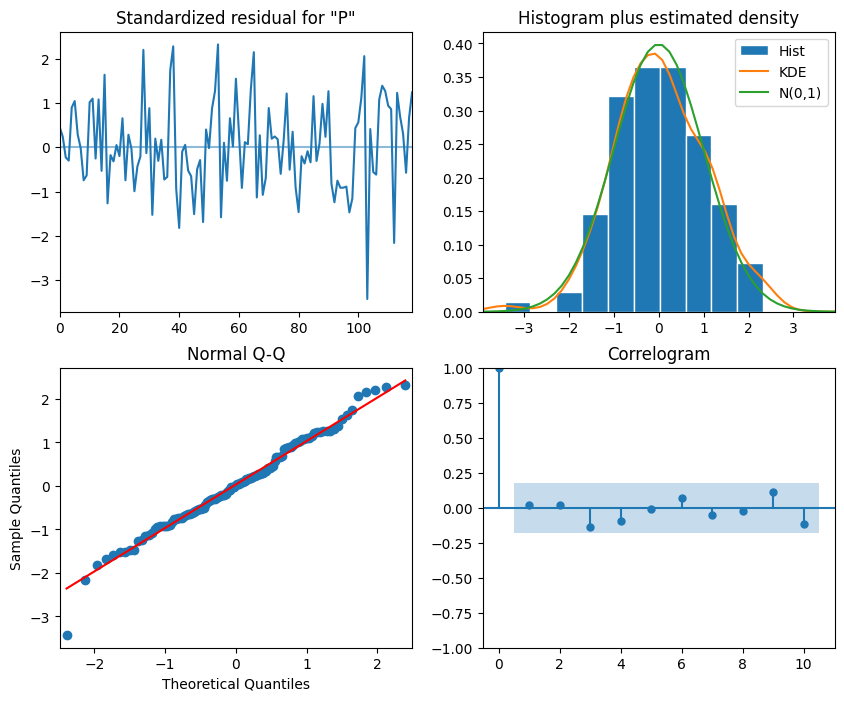

In [47]:
# Extract the residuals (errors) from the fitted model
residuals_sea = SARIMA_model_fit.resid 

# Diagnostic plots for the model, including residuals and other model checks
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

*Residuals’ diagnostics of the SARIMA(2,1,1)(1,1,2)12 model.* The **top-left plot** shows that
the residuals do not exhibit a trend or a change in variance. The **top-right plot** shows that the residuals’
distribution is very close to a normal distribution. This is further supported by the **Q-Q plot** at the bottom
left, which displays a fairly straight line that lies on y = x. Finally, the correlogram at the **bottom right**
shows no significant coefficients after lag 0. Therefore, everything leads to the conclusion that the
residuals resemble white noise.

In [49]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals_sea = acorr_ljungbox(residuals_sea, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals_sea['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals_sea

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.004691,0.945395
2,0.747602,0.688114
3,1.024774,0.795258
4,1.227879,0.873487
5,1.437423,0.920176
6,1.713528,0.944072
7,2.309988,0.940713
8,2.718085,0.950785
9,2.734271,0.973906
10,4.966962,0.893374


In [50]:
# Generate predictions for the test set using the fitted SARIMA model, for timesteps 132 to 143
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean 

# Assign the predicted values to a new column 'SARIMA_pred' in the test dataframe
test['SARIMA_pred'] = SARIMA_pred

# Display the dataframe
test

,Month,Passengers,naive_seasonal,ARIMA_pred,SARIMA_pred
132,1960-01,417,360,422.288587,418.520019
133,1960-02,391,342,410.332218,399.592320
134,1960-03,419,406,461.428614,461.328989
135,1960-04,461,396,457.156875,451.458259
136,1960-05,472,420,481.277206,473.773244
137,1960-06,535,472,530.857382,538.793236
138,1960-07,622,548,605.936664,612.492324
139,1960-08,606,559,615.214999,624.685244
140,1960-09,508,463,525.259655,520.202502
141,1960-10,461,407,467.249150,462.875653


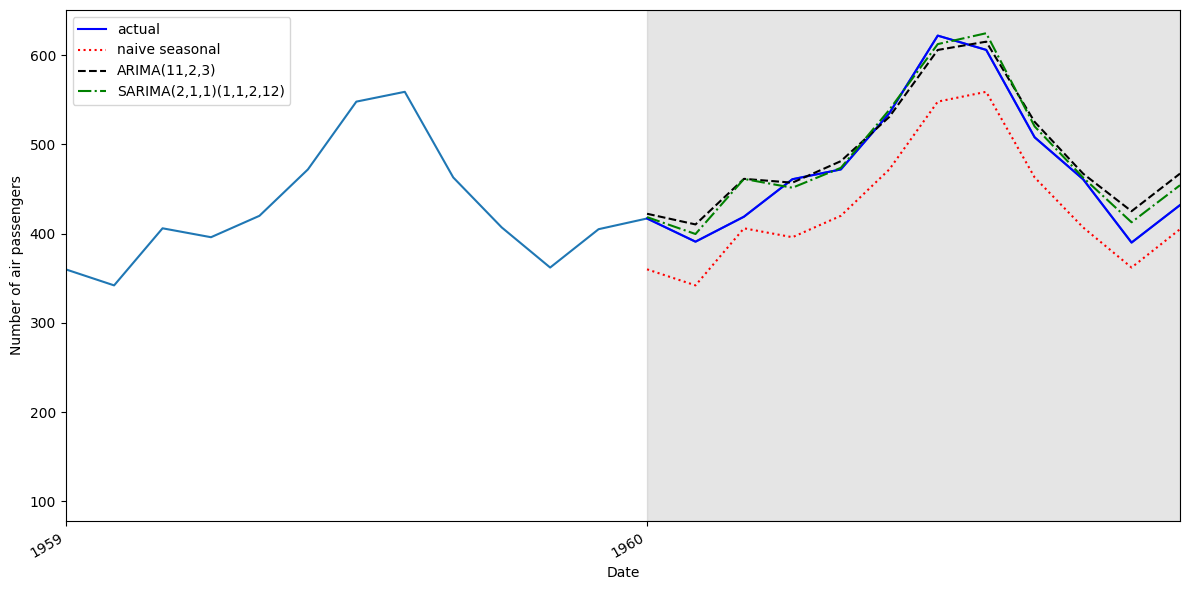

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()

*Forecasts of the number of monthly air passengers. The shaded area designates
the test set. You can see that the curves coming from the ARIMA and SARIMA models
almost obscure the observed data, which is indicative of good predictions.*

In [53]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [54]:
from sklearn.metrics import mean_squared_error

# Calculate the MAPE for each forecast
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

# Display MSE results
print(f'MAPE for Naive Seasonal Forecast): {mape_naive_seasonal:.2f}')
print(f'         MAPE for ARIMA Forecast): {mape_ARIMA:.2f}')
print(f'        MAPE for SARIMA Forecast): {mape_SARIMA:.2f}')

MAPE for Naive Seasonal Forecast): 9.99
         MAPE for ARIMA Forecast): 3.83
        MAPE for SARIMA Forecast): 2.85


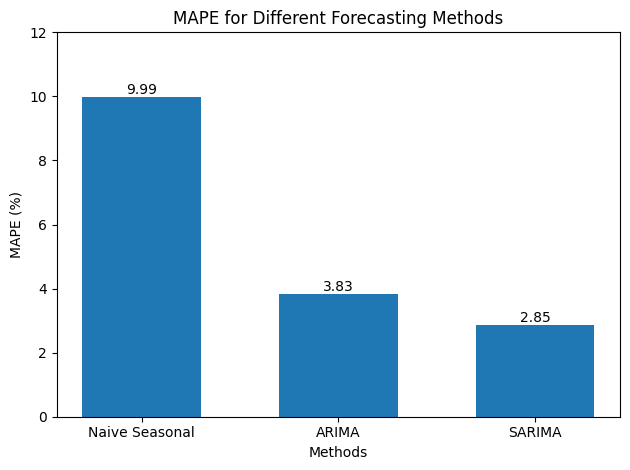

In [55]:
fig, ax = plt.subplots()

x = ['Naive Seasonal', 'ARIMA', 'SARIMA']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Methods')
ax.set_ylabel('MAPE (%)')
ax.set_title('MAPE for Different Forecasting Methods')
ax.set_ylim(0, 12)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

We can see that our baseline achieves a MAPE of 9.99%. The ARIMA
model produced forecasts with a MAPE of 3.83%, and the SARIMA model scored a
MAPE of 2.85%. A MAPE closer to 0 is indicative of better predictions, so the SARIMA model is the best-performing method for this situation. This makes sense, since our
dataset had clear seasonality, and the SARIMA model is built to use the seasonal properties of time series to make forecasts.